In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

In [3]:
# Load dataset (replace with actual data)
df = pd.read_csv('german_credit_train.csv')

In [35]:
def create_features(df):

    df_fe = df.copy()

    # Binary features
    df_fe['is_high_installment'] = (df_fe['InstallmentPercent'] >= 4).astype(int)
    # df_fe['is_young'] = (df_fe['Age'] < 40).astype(int)
    df_fe['is_long_loan'] = (df_fe['LoanDuration'] >= 30).astype(int)
    df_fe['is_large_loan'] = (df_fe['LoanAmount'] >= 5000).astype(int)
    df_fe['is_long_residence'] = (df_fe['CurrentResidenceDuration'] >= 4).astype(int)
    df_fe['no_checking'] = (df_fe['CheckingStatus'] == 'no_checking').astype(int)
    df_fe['bad_credit'] = df_fe['CreditHistory'].isin([
        'outstanding_credit', 'prior_payments_delayed'
    ]).astype(int)

    df_fe['risky_purpose'] = df_fe['LoanPurpose'].isin([
        'appliances', 'business', 'education', 'other', 'ratio_tv', 'repairs'
    ]).astype(int)

    df_fe['long_employment'] = df_fe['EmploymentDuration'].isin([
        'greater_7', '4_to_7'
    ]).astype(int)

    df_fe['NoOtherLoan'] = (df_fe['OthersOnLoan'] == 'none').astype(int)
    df_fe['OwnsPropertyUnknown'] = (df_fe['OwnsProperty'] == 'unknown').astype(int)
    df_fe['HousingFree'] = (df_fe['Housing'] == 'free').astype(int)
    
    # Age x Sex features
    df_fe['YoungMale'] = ((df['Age'] < 30) & (df['Sex'] == 'male')).astype(int)
    df_fe['YoungFemale'] = ((df['Age'] < 30) & (df['Sex'] == 'female')).astype(int)
    df_fe['MiddleMale'] = ((df['Age'] >= 30) & (df['Age'] <= 50) & (df['Sex'] == 'male')).astype(int)
    df_fe['MiddleFemale'] = ((df['Age'] >= 30) & (df['Age'] <= 50) & (df['Sex'] == 'female')).astype(int)
    df_fe['SeniorMale'] = ((df['Age'] > 50) & (df['Sex'] == 'male')).astype(int)
    df_fe['SeniorFemale'] = ((df['Age'] > 50) & (df['Sex'] == 'female')).astype(int)


    # Numerical features

    # Payment to income ratio
    df_fe['InstallmentRatio'] = (df_fe['InstallmentPercent'] / 100) * \
                                 (df_fe['LoanAmount'] / df_fe['LoanDuration'])
    
    # Loan amount to age ratio (higher values might indicate higher risk)
    df_fe['LoanAmountPerAge'] = df_fe['LoanAmount'] / df_fe['Age']

    # Credit utilization proxy (higher values indicate more existing credit relative to income)
    df_fe['CreditUtilization'] = df['ExistingCreditsCount'] * df['LoanAmount'] / (df['Age'] - 18)

    # Loan burden (installment relative to dependents - higher might be riskier)
    df_fe['LoanBurden'] = df['InstallmentPercent'] * (df['Dependents'] + 1)

    return df_fe

In [39]:
numerical_cols = [
    'LoanDuration',
    'LoanAmount',
    'InstallmentPercent',
    'CurrentResidenceDuration',
    'Age',
    'ExistingCreditsCount',
    'InstallmentRatio',
    'LoanAmountPerAge',
    'CreditUtilization',
    'LoanBurden',
]

categorical_cols = [
    'CheckingStatus',
    'CreditHistory',
    'LoanPurpose',
    'ExistingSavings',
    'EmploymentDuration',
    'Sex',
    'OthersOnLoan',
    'OwnsProperty',
    'InstallmentPlans',
    'Housing',
    'Job',
    'Dependents',
    'Telephone',
    'ForeignWorker',]

binary_cols = [
    'is_high_installment',
    # 'is_young',
    'is_long_loan',
    'is_large_loan',
    'is_long_residence',
    'no_checking',
    'bad_credit',
    'long_employment',
    'risky_purpose',
    'NoOtherLoan',
    'OwnsPropertyUnknown',
    'HousingFree',
    'YoungMale',
    'YoungFemale',
    'MiddleMale',
    'MiddleFemale',
    'SeniorMale',
    'SeniorFemale',
]

In [31]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


def compute_costs(LoanAmount):
     return({'Risk_No Risk': 5.0 + .6 * LoanAmount, 'No Risk_No Risk': 1.0 - .05 * LoanAmount,
         'Risk_Risk': 1.0, 'No Risk_Risk': 1.0})
def custom_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
   '''
   A custom metric for the German credit dataset
   '''
   real_prop = {'Risk': .02, 'No Risk': .98}
   train_prop = {'Risk': 1/3, 'No Risk': 2/3}
   custom_weight = {'Risk': real_prop['Risk']/train_prop['Risk'], 'No Risk': real_prop['No Risk']/train_prop['No Risk']}
   costs = compute_costs(solution['LoanAmount'])
   y_true = solution['Risk']
   y_pred = submission['Risk']
   loss = (y_true=='Risk') * custom_weight['Risk'] *\
               ((y_pred=='Risk') * costs['Risk_Risk'] + (y_pred=='No Risk') * costs['Risk_No Risk']) +\
            (y_true=='No Risk') * custom_weight['No Risk'] *\
               ((y_pred=='Risk') * costs['No Risk_Risk'] + (y_pred=='No Risk') * costs['No Risk_No Risk'])
   # return loss.mean()
   return -np.mean(loss)


# Custom scorer that needs access to X
def cost_scorer(estimator, X, y_true):
    # Make predictions
    y_pred = estimator.predict(X)

    # Reconstruct `solution` and `submission` DataFrames
    solution = pd.DataFrame({
        'Risk': ['Risk' if val == 1 else 'No Risk' for val in y_true],
        'LoanAmount': X['LoanAmount'].values  # X must be the raw DataFrame
    })

    submission = pd.DataFrame({
        'Risk': ['Risk' if val == 1 else 'No Risk' for val in y_pred]
    })

    return custom_score(solution, submission, row_id_column_name=None)

# scorer = make_scorer(cost_scorer, greater_is_better=True)


In [32]:
def compute_class_weights(y_data):
    weights = compute_class_weight('balanced', classes=np.unique(y_data), y=y_data)
    class_weights = {0: weights[0], 1: weights[1]}
    sample_weights = [class_weights[label] for label in y_data]
    return sample_weights


In [44]:

# Identify categorical and numerical columns
cat_cols = categorical_cols
num_cols = numerical_cols

# Preprocessing for numerical data
num_transformer = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
cat_transformer = Pipeline([
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols),
    ('binary', 'passthrough', binary_cols)
])

# Choose model type (classification or regression)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Create full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])


In [45]:
# Define target and features
target = "Risk"
X = df.drop(columns=[target])
X = create_features(X)
y = df[target]

# Binary encode target variable if classification
y = LabelEncoder().fit_transform(y) if y.nunique() == 2 else y


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights
sample_weights = compute_class_weights(y_train)


# Define parameter grid for hyperparameter tuning
param_grid1 = {
    'model__n_estimators': [1400, 1500, 1600],
    'model__max_depth': [10, 15, 20],
    'model__learning_rate': [0.1, 0.3, 0.5]
}


# Perform grid search - custom scoring loss function here?
search1 = GridSearchCV(pipeline, param_grid1, cv=5, scoring=cost_scorer, n_jobs=-1)
search1.fit(X_train, y_train,
           model__sample_weight=sample_weights
           )

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LoanDuration',
                                                                          'LoanAmount',
                                                                          'InstallmentPercent',
                                                                          'CurrentResidenceDuration',
                                                                          'Age',
                                                                          'ExistingCreditsCount',
                                                                          'InstallmentRatio',
                                                                          'LoanAmountPerAge',
                                                                          'CreditUtilization',
                                                                          'LoanBurden']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('o...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.3, 0.5],
                         'model__max_depth': [10, 15, 20],
                         'model__n_estimators': [1400, 1500, 1600]},
             scoring=<function cost_scorer at 0x15ff07600>)

In [46]:
# Evaluate model
y_pred = search1.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy: {score:.4f}")

# Best parameters
print("Best parameters:", search1.best_params_)


# Compute actual score
actual_score = cost_scorer(search1.best_estimator_, X_test, y_test)
print(f"Kaggle Score (negative loss): {-actual_score:.4f}")


Accuracy: 0.7600
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__n_estimators': 1400}
Kaggle Score (negative loss): -73.9002


In [47]:
len(X_train.columns)

41

In [54]:
def feature_importance(model, X, y):
    result = permutation_importance(
        model.best_estimator_, X, y,
        n_repeats=10, random_state=42,
        scoring=cost_scorer, n_jobs=-1
    )

    # Use raw column names
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean
    }).sort_values(by='Importance', ascending=False)

    top_features = importance_df[importance_df['Importance']>0]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.gca().invert_yaxis()
    plt.xlabel('Permutation Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return importance_df


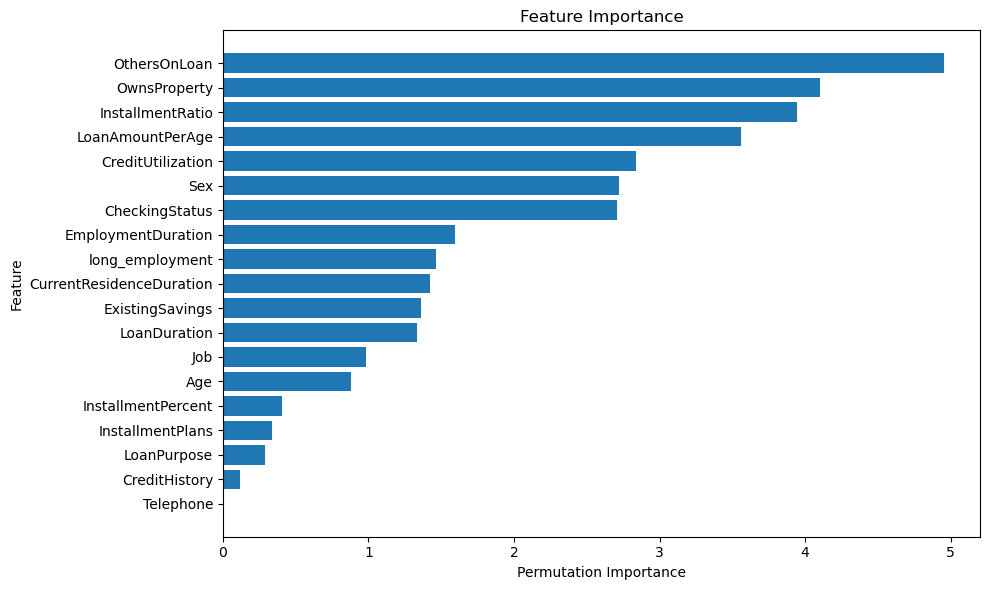

In [55]:
importance_df = feature_importance(search1, X_train, y_train)
top_features = importance_df[importance_df['Importance']>0]['Feature']

In [56]:
# Identify categorical and numerical columns
cat_cols_select = [col for col in top_features if col in categorical_cols]
num_cols_select = [col for col in top_features if col in numerical_cols]
bin_cols_select = [col for col in top_features if col in binary_cols]


# Combine preprocessors in a column transformer
preprocessor_select = ColumnTransformer([
    ('num', num_transformer, num_cols_select),
    ('cat', cat_transformer, cat_cols_select),
    ('binary', 'passthrough', bin_cols_select)
])

# Choose model type (classification or regression)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Create full pipeline
pipeline_select = Pipeline([
    ('preprocessor', preprocessor_select),
    ('model', model)
])

param_grid2 = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [15, 25, 35],
    'model__learning_rate': [0.35, 0.4, 0.5]
}

# Perform grid search
search_select = GridSearchCV(pipeline_select, param_grid2, cv=10, scoring=cost_scorer, n_jobs=-1)
search_select.fit(X_train, y_train,
           model__sample_weight=sample_weights
           )



GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['InstallmentRatio',
                                                                          'LoanAmountPerAge',
                                                                          'CreditUtilization',
                                                                          'CurrentResidenceDuration',
                                                                          'LoanDuration',
                                                                          'Age',
                                                                          'InstallmentPercent']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))])...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.35, 0.4, 0.5],
                         'model__max_depth': [15, 25, 35],
                         'model__n_estimators': [100, 200, 300]},
             scoring=<function cost_scorer at 0x15ff07600>)

In [57]:
# Evaluate model
y_pred_select = search_select.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_pred_select)
print(f"Accuracy: {score:.4f}")

# Best parameters
print("Best parameters:", search_select.best_params_)


# Compute actual score
actual_score = cost_scorer(search_select.best_estimator_, X_test, y_test)
print(f"Kaggle Score (negative loss): {-actual_score:.4f}")

Accuracy: 0.7588
Best parameters: {'model__learning_rate': 0.4, 'model__max_depth': 25, 'model__n_estimators': 100}
Kaggle Score (negative loss): -73.1043


In [58]:
test_df = pd.read_csv('german_credit_test.csv')
X_test_final = test_df.drop(columns=[target], errors='ignore') # Drop target column if it exists
X_test_final = create_features(X_test_final)  # Create features

# Clean best parameters (remove 'model__' prefix)
best_params_clean = {k.replace('model__', ''): v for k, v in search_select.best_params_.items()}

# Generate predictions
final_model = Pipeline([
    ('preprocessor', preprocessor_select),
    ('model', XGBClassifier(
        **best_params_clean,  # Uses best params found in GridSearch
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

final_model.fit(X, y)
y_pred_final = final_model.predict(X_test_final)

predictions_df = pd.DataFrame({
    'Id': test_df['Id'],
    'Risk': ['Risk' if p == 1 else 'No Risk' for p in y_pred_final]}
                              )
# predictions_df.to_csv('german_credit_test_predictions.csv', index=False)